# 3. Data Modeling

After feature engineering and data analysis, the next step is to model the data to understand if the ECG waveform together with basic demographic information could be used as a biometric identification by training a clasification model. 

In [1]:
# Importing packages

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import scipy.signal
import glob
import os
import seaborn as sns
%matplotlib inline
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, r2_score
#import ECG_Biometric_functions as functions

## 3.1 DataFrame preparation

The gender column is converted using one-hot encoding and all NaN values are dropped before training the proposed model.

In [2]:
df_ecg = pd.read_pickle("df_ecg")

In [3]:
df_ecg_gender = pd.get_dummies(df_ecg.Gender)
df_ecg_gender

""


In [4]:
cat_df = df_ecg.select_dtypes(include=["object"])
cat_df.shape[1]
cat_df.isnull().sum().sort_values()

Series([], dtype: float64)

In [39]:
df_ecg = df_ecg.join(df_ecg_gender, how='outer').drop(["Gender"], axis=1)
df_ecg

,Subject_ID,Age,RR,ECG_mean,ECG_std,ECG_var,ECG_median,female,male
0,1,25,1.742,0.003704,0.150695,0.022709,-0.007788,0,1
1,1,25,1.852,0.002228,0.143421,0.020570,-0.008154,0,1
2,1,25,1.824,-0.003523,0.159374,0.025400,-0.031116,0,1
3,1,25,2.542,0.003994,0.140078,0.019622,-0.020022,0,1
4,1,25,1.580,-0.005987,0.144003,0.020737,-0.003448,0,1
...,...,...,...,...,...,...,...,...,...
2667,89,40,1.888,-0.000311,0.131823,0.017377,-0.011826,1,0
2668,89,40,2.790,-0.000270,0.127651,0.016295,-0.005316,1,0
2669,89,40,3.374,-0.000081,0.131299,0.017240,-0.013438,1,0
2670,90,21,NaN,NaN,NaN,NaN,NaN,1,0


In [40]:
df_ecg = df_ecg.dropna()
df_ecg

,Subject_ID,Age,RR,ECG_mean,ECG_std,ECG_var,ECG_median,female,male
0,1,25,1.742,0.003704,0.150695,0.022709,-0.007788,0,1
1,1,25,1.852,0.002228,0.143421,0.020570,-0.008154,0,1
2,1,25,1.824,-0.003523,0.159374,0.025400,-0.031116,0,1
3,1,25,2.542,0.003994,0.140078,0.019622,-0.020022,0,1
4,1,25,1.580,-0.005987,0.144003,0.020737,-0.003448,0,1
...,...,...,...,...,...,...,...,...,...
2665,89,40,2.712,-0.001355,0.136173,0.018543,-0.012523,1,0
2666,89,40,1.822,-0.000329,0.135517,0.018365,-0.018306,1,0
2667,89,40,1.888,-0.000311,0.131823,0.017377,-0.011826,1,0
2668,89,40,2.790,-0.000270,0.127651,0.016295,-0.005316,1,0


## 3.2 Data modeling

This is a classification task with a reduced number of samples (2832 rows), thus a linear SVM could be suitable.

In [41]:
# Model implementation

X = df_ecg.drop('Subject_ID', axis=1)
y = df_ecg['Subject_ID']

#X_train, X_test, y_train, y_test, svmlinear_model, y_preds = functions.svmlinear_model(X, y, test_size = .30, random_state = 42)
#model_accuracy, model_f1score, model_recall, model_precision, rsquared_score = functions.model_performace(y_test, y_preds)

The proposed model shows a low general performance. It could be due to the inadequacy of the model itself or could be due to the several issues that the features appear to introduce (bias, redundancy, inaccuracies, ...). Accordingly, the first step will be to include additional features, saved in Part 1: a portion of the raw (original) ECG signal. In this way, it can be assessed the impact of the features on the model's performance. 

### Adding features: ECG raw data

In [42]:
# Upload the saved ECG samples, drop the rows with all NaN values and fill with zero the remaining NaNs 
df_ecg_samples = pd.read_pickle("df_ecg_samples")
df_ecg_samples = df_ecg_samples.dropna(how="all")
df_ecg_samples = df_ecg_samples.fillna(0)

In [43]:
# Join both DataFrames
df_ecg = df_ecg.join(df_ecg_samples, how='outer')
df_ecg

,Subject_ID,Age,RR,ECG_mean,ECG_std,ECG_var,ECG_median,female,male,ecg_0,...,ecg_5777,ecg_5778,ecg_5779,ecg_5780,ecg_5781,ecg_5782,ecg_5783,ecg_5784,ecg_5785,ecg_5786
0,1,25,1.742,0.003704,0.150695,0.022709,-0.007788,0,1,0.782287,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,25,1.852,0.002228,0.143421,0.020570,-0.008154,0,1,0.845196,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,25,1.824,-0.003523,0.159374,0.025400,-0.031116,0,1,0.813246,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,25,2.542,0.003994,0.140078,0.019622,-0.020022,0,1,0.820452,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,25,1.580,-0.005987,0.144003,0.020737,-0.003448,0,1,0.725434,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2665,89,40,2.712,-0.001355,0.136173,0.018543,-0.012523,1,0,0.541846,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2666,89,40,1.822,-0.000329,0.135517,0.018365,-0.018306,1,0,0.519426,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2667,89,40,1.888,-0.000311,0.131823,0.017377,-0.011826,1,0,0.484997,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2668,89,40,2.790,-0.000270,0.127651,0.016295,-0.005316,1,0,0.496688,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
# Model implementation

X = df_ecg.drop('Subject_ID', axis=1)
y = df_ecg['Subject_ID']

#X_train, X_test, y_train, y_test, svmlinear_model, y_preds = functions.svmlinear_model(X, y, test_size = .30, random_state = 42)
#model_accuracy, model_f1score, model_recall, model_precision, rsquared_score = functions.model_performace(y_test, y_preds)

### Model assessment

In [45]:
#X = np.expand_dims(X, axis=2)
X.shape


(2619, 5795)

In [46]:
y.shape

(2619,)

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score, f1_score
# 將矩陣形狀調整為(2832, 6869, 1)
X_reshaped = np.expand_dims(X, axis=-1)

# 將y矩陣進行one-hot編碼
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
num_classes = len(label_encoder.classes_)

# 將資料集分為訓練集和測試集
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_encoded, test_size=0.2, random_state=42)

# 定義SENet模型
def create_senet_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    
    # 假設您希望使用一個簡單的卷積層作為SENet模型的主體
    x = keras.layers.Conv1D(64, kernel_size=3, activation='relu')(inputs)
    x = keras.layers.MaxPooling1D(pool_size=2)(x)
    x = keras.layers.Flatten()(x)
    
    # Squeeze-and-Excitation塊
    se = keras.layers.Dense(64, activation='relu')(x)
    se = keras.layers.Dense(1, activation='sigmoid')(se)
    x = keras.layers.Multiply()([x, se])
    
    outputs = keras.layers.Dense(num_classes, activation='softmax')(x)
    
    model = keras.Model(inputs=inputs, outputs=outputs)
    
    return model

# 建立SENet模型
model = create_senet_model(input_shape=(5795, 1), num_classes=num_classes)

# 編譯模型
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 訓練模型
history=model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))





Epoch 1/10
66/66 [==============================] - 43s 641ms/step - loss: 3.3828 - accuracy: 0.2272 - val_loss: 2.5904 - val_accuracy: 0.3588
Epoch 2/10
66/66 [==============================] - 40s 601ms/step - loss: 1.4901 - accuracy: 0.6243 - val_loss: 1.8406 - val_accuracy: 0.5534
Epoch 3/10
66/66 [==============================] - 40s 607ms/step - loss: 0.6356 - accuracy: 0.8477 - val_loss: 1.7191 - val_accuracy: 0.6202
Epoch 4/10
66/66 [==============================] - 39s 597ms/step - loss: 0.2954 - accuracy: 0.9422 - val_loss: 1.6859 - val_accuracy: 0.6527
Epoch 5/10
66/66 [==============================] - 39s 591ms/step - loss: 0.1658 - accuracy: 0.9680 - val_loss: 1.6753 - val_accuracy: 0.6527
Epoch 6/10
66/66 [==============================] - 40s 608ms/step - loss: 0.1074 - accuracy: 0.9838 - val_loss: 1.6910 - val_accuracy: 0.6851
Epoch 7/10
66/66 [==============================] - 41s 627ms/step - loss: 0.0548 - accuracy: 0.9947 - val_loss: 1.6952 - val_accuracy: 0.7023

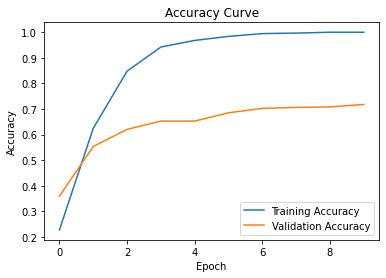

In [49]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()
plt.show()

In [50]:
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)


# 計算混淆矩陣
confusion_mat = confusion_matrix(y_test, predicted_labels)
print("混淆矩陣：")
print(confusion_mat)

recall = recall_score(y_test, y_pred, average='macro')

print("召回率：", recall)

# 計算準確率（Accuracy）
accuracy = accuracy_score(y_test, y_pred)
print("準確率：", accuracy)



# 計算精密度（Precision）
precision = precision_score(y_test, y_pred,average='macro')
print("精密度：", precision)

# 計算F1 分數（F1-score）
f1 = f1_score(y_test, y_pred,average='macro')
print("F1 分數：", f1)

17/17 [==============================] - 1s 77ms/step
混淆矩陣：
[[31  0  0 ...  0  0  0]
 [ 0 33  0 ...  0  0  0]
 [ 1  0 14 ...  0  0  0]
 ...
 [ 0  0  0 ...  1  0  0]
 [ 3  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  1]]
召回率： 0.6275416952758284
準確率： 0.7175572519083969
精密度： 0.6965544100960767
F1 分數： 0.6241598339874054


C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
